# Imports e inicio sesion spark

In [31]:
%%configure -f
{    
    "conf": {
        "spark.jars.packages": "graphframes:graphframes:0.8.2-spark3.2-s_2.12"
    }
}


StatementMeta(upmpracticalabs, 2, -1, Finished, Available)

In [32]:
import random
import math
from operator import add
import numpy as np
import time
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, Bucketizer, VectorAssembler
from pyspark.ml.stat import Correlation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as ply
import seaborn as sns
from graphframes import GraphFrame

StatementMeta(upmpracticalabs, 2, 2, Finished, Available)

In [33]:
spark = SparkSession.builder \
    .appName("Cargar CSV a DataFrame") \
    .getOrCreate()

StatementMeta(upmpracticalabs, 2, 3, Finished, Available)

# Carga de datos

In [34]:
flightsDF = spark.read.csv("abfss://upmpractica-fs@upmpracticadatalake.dfs.core.windows.net/synapse/workspaces/upmpractica-ws/data/flights_jan08.csv", header=True, inferSchema=True)

StatementMeta(upmpracticalabs, 2, 4, Finished, Available)

In [4]:
flightsDF.printSchema()

StatementMeta(upmpracticalabs, 1, 5, Finished, Available)

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

In [5]:
flightsDF.select(flightsDF.columns[:6]).show(3)
flightsDF.select(flightsDF.columns[:6]).summary().show()

StatementMeta(upmpracticalabs, 1, 6, Finished, Available)

+----+-----+----------+---------+-------+----------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|
+----+-----+----------+---------+-------+----------+
|2008|    1|         3|        4|   2003|      1955|
|2008|    1|         3|        4|    754|       735|
|2008|    1|         3|        4|    628|       620|
+----+-----+----------+---------+-------+----------+
only showing top 3 rows

+-------+------+------+-----------------+------------------+-----------------+-----------------+
|summary|  Year| Month|       DayofMonth|         DayOfWeek|          DepTime|       CRSDepTime|
+-------+------+------+-----------------+------------------+-----------------+-----------------+
|  count|100000|100000|           100000|            100000|           100000|           100000|
|   mean|2008.0|   1.0|         17.08786|           3.89004|1355.200722248073|        1341.9894|
| stddev|   0.0|   0.0|8.356363976550425|1.9529994727263513|464.0896318178067|451.3569842141706|
|    min|  2008|     1

In [6]:
flightsDF.select(flightsDF.columns[6:12]).show(3)
flightsDF.select(flightsDF.columns[6:12]).summary().show()

StatementMeta(upmpracticalabs, 1, 7, Finished, Available)

+-------+----------+-------------+---------+-------+-----------------+
|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|
+-------+----------+-------------+---------+-------+-----------------+
|   2211|      2225|           WN|      335| N712SW|              128|
|   1002|      1000|           WN|     3231| N772SW|              128|
|    804|       750|           WN|      448| N428WN|               96|
+-------+----------+-------------+---------+-------+-----------------+
only showing top 3 rows

+-------+------------------+------------------+-------------+------------------+-------+------------------+
|summary|           ArrTime|        CRSArrTime|UniqueCarrier|         FlightNum|TailNum| ActualElapsedTime|
+-------+------------------+------------------+-------------+------------------+-------+------------------+
|  count|            100000|            100000|       100000|            100000|  98858|            100000|
|   mean|1492.7392247056678|        1502.60154

In [7]:
flightsDF.select(flightsDF.columns[12:18]).show(3)
flightsDF.select(flightsDF.columns[12:18]).summary().show()

StatementMeta(upmpracticalabs, 1, 8, Finished, Available)

+--------------+-------+--------+--------+------+----+
|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|
+--------------+-------+--------+--------+------+----+
|           150|    116|     -14|       8|   IAD| TPA|
|           145|    113|       2|      19|   IAD| TPA|
|            90|     76|      14|       8|   IND| BWI|
+--------------+-------+--------+--------+------+----+
only showing top 3 rows

+-------+-----------------+-----------------+------------------+------------------+------+------+
|summary|   CRSElapsedTime|          AirTime|          ArrDelay|          DepDelay|Origin|  Dest|
+-------+-----------------+-----------------+------------------+------------------+------+------+
|  count|           100000|           100000|            100000|            100000|100000|100000|
|   mean|        111.98954| 91.8637966321506| 5.729954001094247|10.379048736571649|  null|  null|
| stddev|57.20913510480482|54.20822434609608|30.966959272464596|28.384428068170923|  null|  null|
| 

In [8]:
flightsDF.select(flightsDF.columns[18:23]).show(3)
flightsDF.select(flightsDF.columns[18:23]).summary().show()

StatementMeta(upmpracticalabs, 1, 9, Finished, Available)

+--------+------+-------+---------+----------------+
|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|
+--------+------+-------+---------+----------------+
|     810|     4|      8|        0|            null|
|     810|     5|     10|        0|            null|
|     515|     3|     17|        0|            null|
+--------+------+-------+---------+----------------+
only showing top 3 rows

+-------+-----------------+-----------------+------------------+-------------------+----------------+
|summary|         Distance|           TaxiIn|           TaxiOut|          Cancelled|CancellationCode|
+-------+-----------------+-----------------+------------------+-------------------+----------------+
|  count|           100000|           100000|            100000|             100000|            1142|
|   mean|        630.58632|4.768961883726114|10.927765077181412|            0.01142|            null|
| stddev|437.3570752611298|2.983635448088944|  5.98957959142771|0.10625298347324162|          

In [9]:
flightsDF.select(flightsDF.columns[23:28]).show(3)
flightsDF.select(flightsDF.columns[23:28]).summary().show()

StatementMeta(upmpracticalabs, 1, 10, Finished, Available)

+--------+------------+------------+--------+-------------+
|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|
+--------+------------+------------+--------+-------------+
|       0|          NA|          NA|      NA|           NA|
|       0|          NA|          NA|      NA|           NA|
|       0|          NA|          NA|      NA|           NA|
+--------+------------+------------+--------+-------------+
only showing top 3 rows

+-------+-------------------+------------------+------------------+-----------------+-------------------+
|summary|           Diverted|      CarrierDelay|      WeatherDelay|         NASDelay|      SecurityDelay|
+-------+-------------------+------------------+------------------+-----------------+-------------------+
|  count|             100000|            100000|            100000|           100000|             100000|
|   mean|             0.0016| 9.573488206225482|2.0361200264914157|8.353150950124816|0.11080544092923736|
| stddev|0.03996818703118

In [10]:
flightsDF.select(flightsDF.columns[28:]).show(3)
flightsDF.select(flightsDF.columns[28:]).summary().show()

StatementMeta(upmpracticalabs, 1, 11, Finished, Available)

+-----------------+
|LateAircraftDelay|
+-----------------+
|               NA|
|               NA|
|               NA|
+-----------------+
only showing top 3 rows

+-------+-----------------+
|summary|LateAircraftDelay|
+-------+-----------------+
|  count|           100000|
|   mean|29.34367517448673|
| stddev| 39.7535288907286|
|    min|                0|
|    25%|              1.0|
|    50%|             18.0|
|    75%|             37.0|
|    max|               NA|
+-------+-----------------+



In [11]:
num_filas = flightsDF.count()
print("Número de filas:", num_filas)
print("Número de columnas:", len(flightsDF.columns))

StatementMeta(upmpracticalabs, 1, 12, Finished, Available)

Número de filas: 100000
Número de columnas: 29


El dataset está compuesto por las siguientes variables:

1. **Year** 2008
2. **Month** 1
3. **DayofMonth** 1-31
4. **DayOfWeek** 1 (Monday) - 7 (Sunday)
5. **DepTime** hora real de salida (local, hhmm)
6. **CRSDepTime** hora prevista de salida (local, hhmm)
7. **ArrTime** hora real de llegada (local, hhmm)
8. **CRSArrTime** hora prevista de llegada (local, hhmm)
9. **UniqueCarrier** código del aparato
10. **FlightNum** número de vuelo
11. **TailNum** identificador de cola: aircraft registration, unique aircraft identifier
12. **ActualElapsedTime** tiempo real invertido en el vuelo
13. **CRSElapsedTime** en minutos
14. **AirTime** en minutos
15. **ArrDelay** retraso a la llegada, en minutos: se considera que un vuelo ha llegado "on time" si aterrizó menos de 15 minutos más tarde de la hora prevista en el Computerized Reservations Systems (CRS).
16. **DepDelay** retraso a la salida, en minutos
17. **Origin** código IATA del aeropuerto de origen
18. **Dest** código IATA del aeropuerto de destino
19. **Distance** en millas
20. **TaxiIn** taxi in time, in minutes
21. **TaxiOut** taxi out time in minutes
22. **Cancelled** *si el vuelo fue cancelado (1 = sí, 0 = no)
23. **CancellationCode** razón de cancelación (A = aparato, B = tiempo atmosférico, C = NAS, D = seguridad)
24. **Diverted** *si el vuelo ha sido desviado (1 = sí, 0 = no)
25. **CarrierDelay** en minutos: El retraso del transportista está bajo el control del transportista aéreo. Ejemplos de sucesos que pueden determinar el retraso del transportista son: limpieza de la aeronave, daño de la aeronave, espera de la llegada de los pasajeros o la tripulación de conexión, equipaje, impacto de un pájaro, carga de equipaje, servicio de comidas, computadora, equipo del transportista, problemas legales de la tripulación (descanso del piloto o acompañante) , daños por mercancías peligrosas, inspección de ingeniería, abastecimiento de combustible, pasajeros discapacitados, tripulación retrasada, servicio de inodoros, mantenimiento, ventas excesivas, servicio de agua potable, denegación de viaje a pasajeros en mal estado, proceso de embarque muy lento, equipaje de mano no válido, retrasos de peso y equilibrio.
26. **WeatherDelay** en minutos: causado por condiciones atmosféricas extremas o peligrosas, previstas o que se han manifestado antes del despegue, durante el viaje, o a la llegada.
27. **NASDelay** en minutos: retraso causado por el National Airspace System (NAS) por motivos como condiciones meteorológicas (perjudiciales pero no extremas), operaciones del aeropuerto, mucho tráfico aéreo, problemas con los controladores aéreos, etc.
28. **SecurityDelay** en minutos: causado por la evacuación de una terminal, re-embarque de un avión debido a brechas en la seguridad, fallos en dispositivos del control de seguridad, colas demasiado largas en el control de seguridad, etc.
29. **LateAircraftDelay** en minutos: debido al propio retraso del avión al llegar, problemas para conseguir aterrizar en un aeropuerto a una hora más tardía de la que estaba prevista.

In [12]:
null_counts = [flightsDF.where(F.col(c).isNull()).count() for c in flightsDF.columns]

na_counts = [flightsDF.where(F.col(c) == "NA").count() for c in flightsDF.columns]

for i, col_name in enumerate(flightsDF.columns):
    print(f"Columna '{col_name}': Valores nulos: {null_counts[i]}, Valores NA: {na_counts[i]}")

StatementMeta(upmpracticalabs, 1, 13, Finished, Available)

Columna 'Year': Valores nulos: 0, Valores NA: 0
Columna 'Month': Valores nulos: 0, Valores NA: 0
Columna 'DayofMonth': Valores nulos: 0, Valores NA: 0
Columna 'DayOfWeek': Valores nulos: 0, Valores NA: 0
Columna 'DepTime': Valores nulos: 0, Valores NA: 1142
Columna 'CRSDepTime': Valores nulos: 0, Valores NA: 0
Columna 'ArrTime': Valores nulos: 0, Valores NA: 1302
Columna 'CRSArrTime': Valores nulos: 0, Valores NA: 0
Columna 'UniqueCarrier': Valores nulos: 0, Valores NA: 0
Columna 'FlightNum': Valores nulos: 0, Valores NA: 0
Columna 'TailNum': Valores nulos: 1142, Valores NA: 0
Columna 'ActualElapsedTime': Valores nulos: 0, Valores NA: 1302
Columna 'CRSElapsedTime': Valores nulos: 0, Valores NA: 0
Columna 'AirTime': Valores nulos: 0, Valores NA: 1302
Columna 'ArrDelay': Valores nulos: 0, Valores NA: 1302
Columna 'DepDelay': Valores nulos: 0, Valores NA: 1142
Columna 'Origin': Valores nulos: 0, Valores NA: 0
Columna 'Dest': Valores nulos: 0, Valores NA: 0
Columna 'Distance': Valores nulo

# Limpieza de los datos

Pese a tener un gran número de diferentes datos y columnas, la gran mayoría son inútiles para la tarea que queremos realizar.

Procedemos a crear un nuevo dataset con los datos que nos interesan, que son:
**DayOfWeek**, **TailNum**, **Origin**, **Dest**, **DepTime**, **DepDelay**, **ArrTime** y **ArrDelay** (la cual será la variable objetivo a predecir).

Además, procedemos a eliminar las filas que contengan datos faltantes (NA) y las convertimos a tipo Integer.

In [13]:
grafFlightsDF = flightsDF.select("DayOfWeek", "TailNum", "Origin", "Dest", "DepTime", "DepDelay", "ArrTime", "ArrDelay", "Distance")\
                          .where("ArrDelay != 'NA' and DepDelay != 'NA' and DepTime != 'NA' and ArrTime != 'NA' and TailNum != 'NA'")\
                          .withColumn("DepTime", F.col("DepTime").cast(IntegerType()))\
                          .withColumn("ArrTime", F.col("ArrTime").cast(IntegerType()))\
                          .withColumn("ArrDelay", F.col("ArrDelay").cast(IntegerType()))\
                          .withColumn("DepDelay", F.col("DepDelay").cast(IntegerType()))

cleanFlightsDF = grafFlightsDF.drop("Distance")

StatementMeta(upmpracticalabs, 1, 14, Finished, Available)

In [14]:
cleanFlightsDF.printSchema()

StatementMeta(upmpracticalabs, 1, 15, Finished, Available)

root
 |-- DayOfWeek: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)



In [15]:
cleanFlightsDF.show(5)

StatementMeta(upmpracticalabs, 1, 16, Finished, Available)

+---------+-------+------+----+-------+--------+-------+--------+
|DayOfWeek|TailNum|Origin|Dest|DepTime|DepDelay|ArrTime|ArrDelay|
+---------+-------+------+----+-------+--------+-------+--------+
|        4| N712SW|   IAD| TPA|   2003|       8|   2211|     -14|
|        4| N772SW|   IAD| TPA|    754|      19|   1002|       2|
|        4| N428WN|   IND| BWI|    628|       8|    804|      14|
|        4| N612SW|   IND| BWI|    926|      -4|   1054|      -6|
|        4| N464WN|   IND| BWI|   1829|      34|   1959|      34|
+---------+-------+------+----+-------+--------+-------+--------+
only showing top 5 rows



In [16]:
cleanFlightsDF.summary().show()

StatementMeta(upmpracticalabs, 1, 17, Finished, Available)

+-------+------------------+-------+------+-----+------------------+-----------------+------------------+------------------+
|summary|         DayOfWeek|TailNum|Origin| Dest|           DepTime|         DepDelay|           ArrTime|          ArrDelay|
+-------+------------------+-------+------+-----+------------------+-----------------+------------------+------------------+
|  count|             98698|  98698| 98698|98698|             98698|            98698|             98698|             98698|
|   mean| 3.892956290907617|   null|  null| null|1355.0917647774017|10.33054367869663|1492.7392247056678| 5.729954001094247|
| stddev|1.9547814932045995|   null|  null| null|464.04576525630847|28.25640518188245|496.37679391699174|30.966959272464596|
|    min|                 1| N11109|   ABQ|  ABQ|                 1|              -44|                 1|               -57|
|    25%|                 2|   null|  null| null|               942|               -2|              1114|                -9|


In [17]:
null_counts = [cleanFlightsDF.where(F.col(c).isNull()).count() for c in cleanFlightsDF.columns]

na_counts = [cleanFlightsDF.where(F.col(c) == "NA").count() for c in cleanFlightsDF.columns]

for i, col_name in enumerate(cleanFlightsDF.columns):
    print(f"Columna '{col_name}': Valores nulos: {null_counts[i]}, Valores NA: {na_counts[i]}")

StatementMeta(upmpracticalabs, 1, 18, Finished, Available)

Columna 'DayOfWeek': Valores nulos: 0, Valores NA: 0
Columna 'TailNum': Valores nulos: 0, Valores NA: 0
Columna 'Origin': Valores nulos: 0, Valores NA: 0
Columna 'Dest': Valores nulos: 0, Valores NA: 0
Columna 'DepTime': Valores nulos: 0, Valores NA: 0
Columna 'DepDelay': Valores nulos: 0, Valores NA: 0
Columna 'ArrTime': Valores nulos: 0, Valores NA: 0
Columna 'ArrDelay': Valores nulos: 0, Valores NA: 0


In [18]:
num_filas = cleanFlightsDF.count()
print("Número de filas:", num_filas)
print("Número de columnas:", len(cleanFlightsDF.columns))

StatementMeta(upmpracticalabs, 1, 19, Finished, Available)

Número de filas: 98698
Número de columnas: 8


Vemos que de 100000 filas solo hemos borrado 1302 (1.3%), por lo que no es una perdida importante con tal de limpiar los datos.

# Análisis de los datos

In [19]:
flights_per_day = cleanFlightsDF.groupBy("DayOfWeek").count().orderBy("DayOfWeek")

StatementMeta(upmpracticalabs, 1, 20, Finished, Available)

In [20]:
pandas_df = flights_per_day.toPandas()
pandas_df = pandas_df.rename(columns={"count": "Number of flights", "DayOfWeek": "Day of the week"})
days_map = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
pandas_df["Day of the week"] = pandas_df["Day of the week"].map(days_map)


StatementMeta(upmpracticalabs, 1, 21, Finished, Available)

StatementMeta(upmpracticalabs, 1, 22, Finished, Available)

<function matplotlib.pyplot.show(close=None, block=None)>

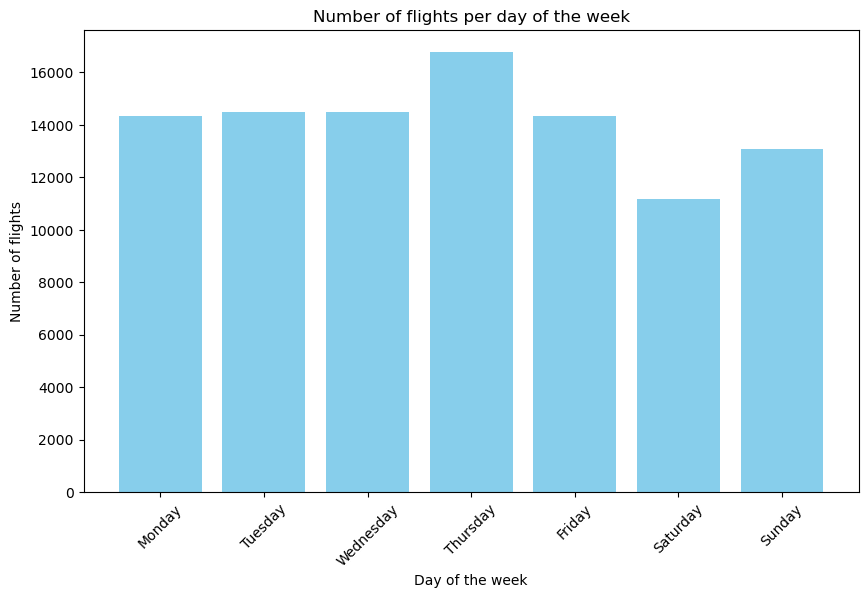

In [21]:
import matplotlib.pyplot as plta
plt.figure(figsize=(10,6))
plt.bar(pandas_df["Day of the week"], pandas_df["Number of flights"], color="skyblue")
plt.xlabel("Day of the week")
plt.ylabel("Number of flights")
plt.title("Number of flights per day of the week")
plt.xticks(rotation=45)
plt.show

StatementMeta(upmpracticalabs, 1, 23, Finished, Available)

<function matplotlib.pyplot.show(close=None, block=None)>

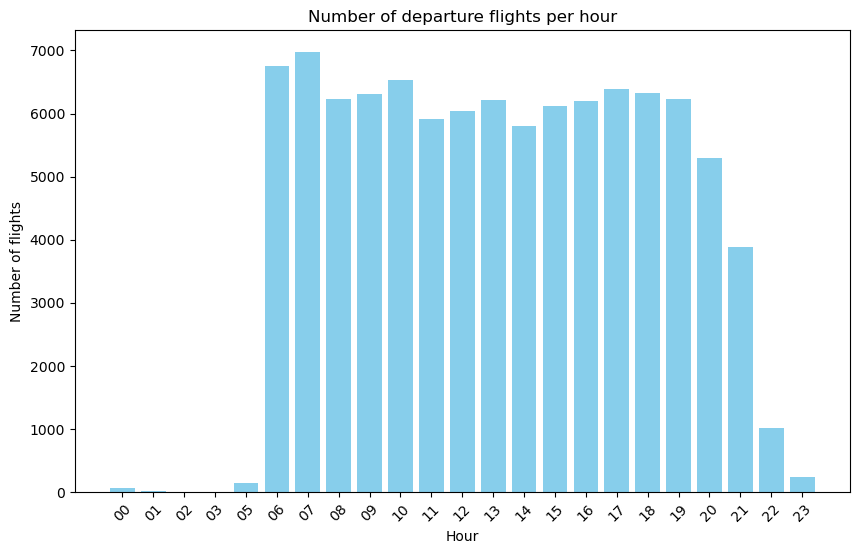

In [22]:
tmpFlightsDF = cleanFlightsDF.withColumn("Hour",F.lpad(F.col("DepTime"),4,"0").substr(1,2))

flights_per_hour = tmpFlightsDF.groupBy("Hour").count().orderBy("Hour")

pandas_df = flights_per_hour.toPandas()
pandas_df = pandas_df.rename(columns={"count": "Number of flights"})

plt.figure(figsize=(10,6))
plt.bar(pandas_df["Hour"], pandas_df["Number of flights"], color="skyblue")
plt.xlabel("Hour")
plt.ylabel("Number of flights")
plt.title("Number of departure flights per hour")
plt.xticks(rotation=45)
plt.show


StatementMeta(upmpracticalabs, 1, 24, Finished, Available)

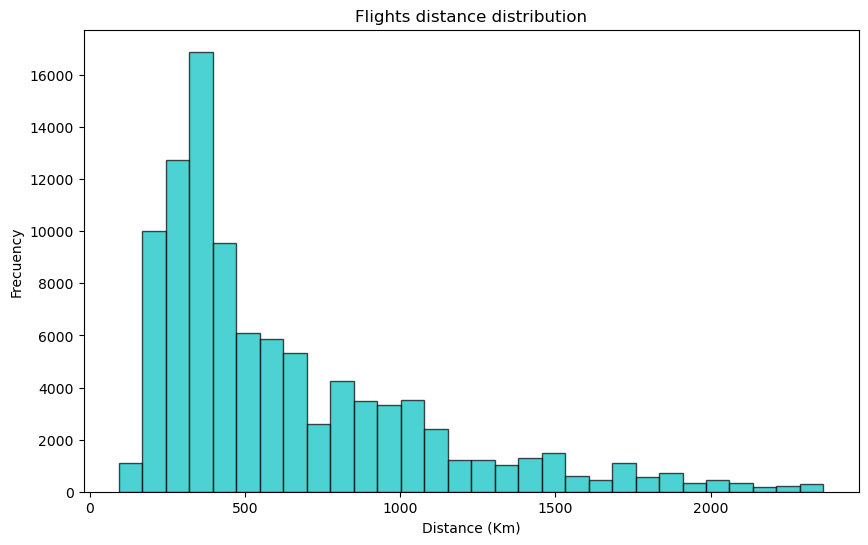

In [23]:
pandas_df = grafFlightsDF.toPandas()

plt.figure(figsize=(10,6))

plt.hist(pandas_df["Distance"], bins=30, color="c", edgecolor="k", alpha=0.7)
plt.xlabel("Distance (Km)")
plt.ylabel("Frecuency")
plt.title("Flights distance distribution")
plt.show()

In [24]:
delay_by_airline = cleanFlightsDF.groupBy("Origin").agg(F.avg("ArrDelay").alias("AverageArrivalDelay"), F.avg("DepDelay").alias("AverageDepartureDelay")).orderBy("AverageArrivalDelay")


StatementMeta(upmpracticalabs, 1, 25, Finished, Available)

StatementMeta(upmpracticalabs, 1, 26, Finished, Available)

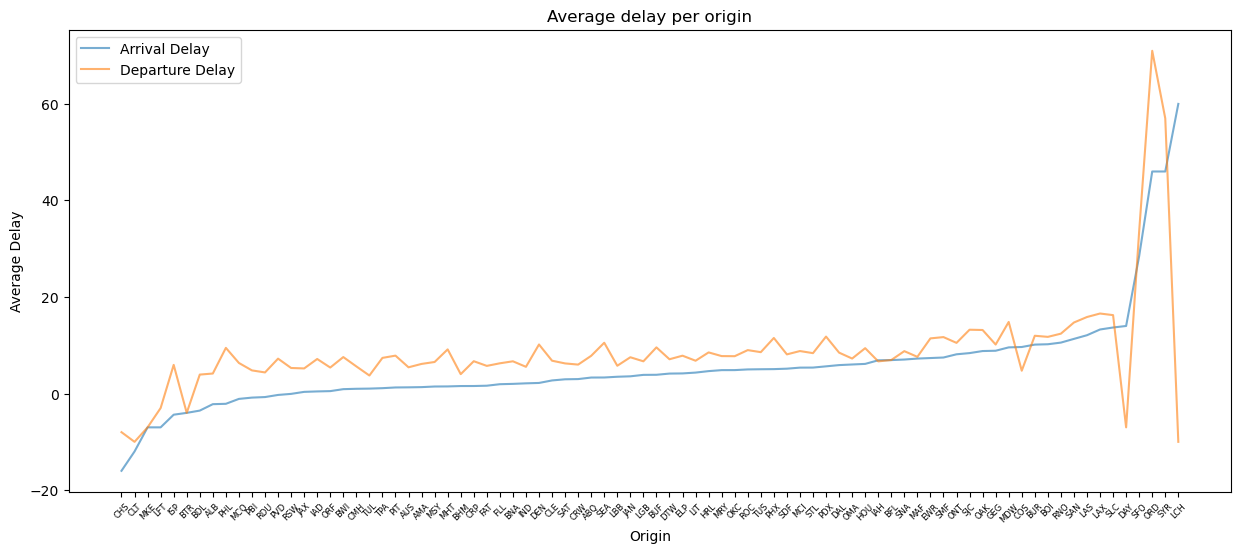

In [25]:
pandas_df = delay_by_airline.toPandas()



plt.figure(figsize=(15,6))
plt.plot(pandas_df["Origin"], pandas_df["AverageArrivalDelay"], alpha=0.6, label="Arrival Delay")
plt.plot(pandas_df["Origin"], pandas_df["AverageDepartureDelay"], alpha=0.6, label="Departure Delay")
plt.xlabel("Origin")
plt.ylabel("Average Delay")
plt.title("Average delay per origin")
plt.legend()
plt.xticks(rotation=45, fontsize=6)
plt.show()

## Matriz de correlaciones

In [26]:
org_dest = grafFlightsDF.select("Origin").union(grafFlightsDF.select(F.col("Dest").alias("Origin"))).distinct()

indexer = StringIndexer(inputCol="Origin", outputCol="index")
org_dest_indexer = indexer.fit(org_dest).transform(org_dest)

#org_dest_indexer = org_dest_indexer.withColumn("index", F.col("index").cast(IntegerType()))
#org_dest_indexer.show(3)

grafFlightsDF_indexes_origin = grafFlightsDF.join(org_dest_indexer, "Origin", "left").withColumnRenamed("index","index_origin")

# grafFlightsDF_indexes_origin.show()

grafFlightsDF_indexes_origin_dest = grafFlightsDF_indexes_origin.join(org_dest_indexer.withColumnRenamed("Origin","Dest"), "Dest", "left").withColumnRenamed("index","index_dest")
grafFlightsDF_indexes_origin_dest.show(5)

StatementMeta(upmpracticalabs, 1, 27, Finished, Available)

+----+------+---------+-------+-------+--------+-------+--------+--------+------------+----------+
|Dest|Origin|DayOfWeek|TailNum|DepTime|DepDelay|ArrTime|ArrDelay|Distance|index_origin|index_dest|
+----+------+---------+-------+-------+--------+-------+--------+--------+------------+----------+
| TPA|   IAD|        4| N712SW|   2003|       8|   2211|     -14|     810|        35.0|      86.0|
| TPA|   IAD|        4| N772SW|    754|      19|   1002|       2|     810|        35.0|      86.0|
| BWI|   IND|        4| N428WN|    628|       8|    804|      14|     515|        37.0|      13.0|
| BWI|   IND|        4| N612SW|    926|      -4|   1054|      -6|     515|        37.0|      13.0|
| BWI|   IND|        4| N464WN|   1829|      34|   1959|      34|     515|        37.0|      13.0|
+----+------+---------+-------+-------+--------+-------+--------+--------+------------+----------+
only showing top 5 rows



In [27]:
columns = grafFlightsDF_indexes_origin_dest.drop("TailNum","Dest","Origin").columns

assembler = VectorAssembler(inputCols=columns, outputCol="features")

df_vector = assembler.transform(grafFlightsDF_indexes_origin_dest).select("features")

matrix = Correlation.corr(df_vector, "features").head()

correlation_matrix = matrix[0].toArray()

print("Correlation_matrix:\n", correlation_matrix)

StatementMeta(upmpracticalabs, 1, 28, Finished, Available)

Correlation_matrix:
 [[ 1.          0.03111076  0.0982202   0.02194688  0.08529901  0.01752531
   0.00235733  0.00164833]
 [ 0.03111076  1.          0.25725889  0.79690258  0.23241529 -0.05684925
   0.01308286  0.01214039]
 [ 0.0982202   0.25725889  1.          0.0911642   0.9422735   0.00968305
   0.03883576  0.02932398]
 [ 0.02194688  0.79690258  0.0911642   1.          0.07635281  0.02467485
   0.01800977  0.01216676]
 [ 0.08529901  0.23241529  0.9422735   0.07635281  1.         -0.08141473
   0.03223838  0.03056958]
 [ 0.01752531 -0.05684925  0.00968305  0.02467485 -0.08141473  1.
   0.02722666  0.02689245]
 [ 0.00235733  0.01308286  0.03883576  0.01800977  0.03223838  0.02722666
   1.          0.06294097]
 [ 0.00164833  0.01214039  0.02932398  0.01216676  0.03056958  0.02689245
   0.06294097  1.        ]]


StatementMeta(upmpracticalabs, 1, 29, Finished, Available)

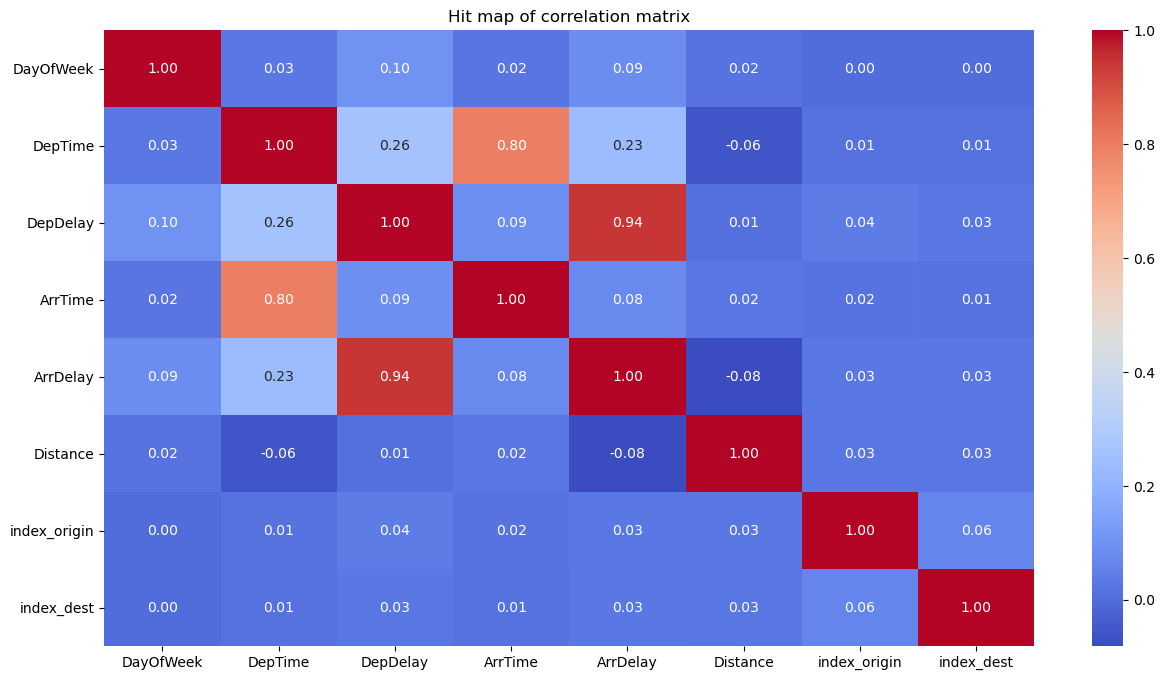

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=columns, yticklabels=columns)
plt.title("Hit map of correlation matrix")
plt.show()

# Analisis de grafos

In [35]:
verticesDF = flightsDF.select(F.col("Origin").alias("id")).distinct().cache()
edgesDF = flightsDF.withColumnRenamed("Origin", "src")\
                   .withColumnRenamed("Dest", "dst")\
                   .select("src", "dst", "Distance")\
                   .distinct()\
                   .cache()

StatementMeta(upmpracticalabs, 2, 5, Finished, Available)

In [36]:
graph = GraphFrame(verticesDF, edgesDF)

StatementMeta(upmpracticalabs, 2, 6, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.


Exploramos los aeropuertos con más vuelos como aquellos con el grado más alto en su vértice (vuelos de salida y llegada)

In [37]:
graph.degrees.orderBy(F.col("degree").desc()).show(3)

StatementMeta(upmpracticalabs, 2, 7, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.


+---+------+
| id|degree|
+---+------+
|LAS|   108|
|MDW|    94|
|PHX|    84|
+---+------+
only showing top 3 rows



In [40]:
graph.inDegrees.orderBy(F.col("inDegree").desc()).show(3)

StatementMeta(upmpracticalabs, 2, 10, Finished, Available)

+---+--------+
| id|inDegree|
+---+--------+
|LAS|      54|
|MDW|      47|
|PHX|      42|
+---+--------+
only showing top 3 rows



In [41]:
graph.outDegrees.orderBy(F.col("outDegree").desc()).show(3)

StatementMeta(upmpracticalabs, 2, 11, Finished, Available)

+---+---------+
| id|outDegree|
+---+---------+
|LAS|       54|
|MDW|       47|
|PHX|       42|
+---+---------+
only showing top 3 rows



Los Ángeles International Airport es el aeropuesto con mas vuelos tanto de llegada como de salida.

Determinamos la importancia de los vertices utilizando pagerank, lo que nos indicala importancia estratégica de cada aeropuesto.

In [43]:
ranks = graph.pageRank(resetProbability=0.15, maxIter=10)
ranks.vertices.orderBy(F.col("pagerank").desc()).show()

StatementMeta(upmpracticalabs, 2, 13, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+------------------+
| id|          pagerank|
+---+------------------+
|LAS| 3.968100588086894|
|MDW|3.4641885967395822|
|PHX|2.9996296419306288|
|BWI| 2.859044345021574|
|MCO| 2.506806330762528|
|TPA| 2.325980728922274|
|ABQ|  2.28062606472766|
|HOU| 2.242821989285586|
|BNA| 2.139348754394598|
|SAN|  2.10337109753917|
|MCI|1.9976511399324188|
|AUS|1.8642893476111473|
|STL| 1.826382254660483|
|ONT|1.7722329347353263|
|SAT| 1.530355131859799|
|OAK|1.4886721798643956|
|SMF|1.4779258223049847|
|LAX|1.4134227909403223|
|SLC| 1.362280151671023|
|JAX|1.2637766842227056|
+---+------------------+
only showing top 20 rows



Nuevamente Los Ángeles International Airport sale como el aeropuerto mas estrategico.

Ahora trataremos de encontrar rutas entre aeropuertos que no esten directamente conectados pero a los que se puede llegar solo realizando una escala

In [44]:
res = graph\
 .find("(a)-[]->(b); (b)-[]->(c); !(a)-[]->(c)")\
 .filter("c.id !=a.id")

res.show()

StatementMeta(upmpracticalabs, 2, 14, Finished, Available)

+-----+-----+-----+
|    a|    b|    c|
+-----+-----+-----+
|{BUF}|{LAS}|{MAF}|
|{SJC}|{PHX}|{ABQ}|
|{SDF}|{PHX}|{ABQ}|
|{PDX}|{MDW}|{ISP}|
|{IAH}|{BNA}|{PHX}|
|{ABQ}|{LAX}|{BNA}|
|{CLE}|{BWI}|{SAT}|
|{BNA}|{TPA}|{PBI}|
|{PDX}|{LAS}|{BWI}|
|{PBI}|{BWI}|{FLL}|
|{AUS}|{MDW}|{PVD}|
|{SEA}|{DEN}|{OKC}|
|{AUS}|{MCI}|{PDX}|
|{AUS}|{PHX}|{STL}|
|{BUR}|{PHX}|{STL}|
|{OMA}|{LAS}|{SFO}|
|{RSW}|{BWI}|{BDL}|
|{OKC}|{BWI}|{BDL}|
|{GEG}|{LAS}|{PHX}|
|{DAL}|{BHM}|{RDU}|
+-----+-----+-----+
only showing top 20 rows



Ahora miramos a los aeropuertos que solo se conectan a travez de dos escalas

In [48]:
res = graph\
 .find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(d); !(a)-[]->(c); !(a)-[]->(d); !(b)-[]->(d)")\
     .filter("a.id != b.id")\
    .filter("a.id != c.id")\
    .filter("a.id != d.id")\
    .filter("b.id != c.id")\
    .filter("b.id != d.id")\
    .filter("c.id != d.id")

res.show()

StatementMeta(upmpracticalabs, 2, 18, Finished, Available)

+-----+-----+-----+-----+
|    a|    b|    c|    d|
+-----+-----+-----+-----+
|{IAH}|{SLC}|{MDW}|{DTW}|
|{OMA}|{PHX}|{BWI}|{ISP}|
|{RDU}|{TPA}|{STL}|{CLE}|
|{PBI}|{TPA}|{PHX}|{PDX}|
|{CMH}|{PHX}|{RDU}|{IAH}|
|{SEA}|{SMF}|{SAT}|{HOU}|
|{SNA}|{SJC}|{MDW}|{CMH}|
|{FLL}|{HOU}|{OAK}|{SEA}|
|{LAX}|{STL}|{BWI}|{JAX}|
|{SAT}|{SMF}|{GEG}|{LGB}|
|{SEA}|{DEN}|{MCO}|{MSY}|
|{BNA}|{SAN}|{TUL}|{STL}|
|{BOI}|{OAK}|{HOU}|{LIT}|
|{COS}|{ONT}|{PHX}|{SDF}|
|{GEG}|{OAK}|{PHX}|{SJC}|
|{JAX}|{BWI}|{SLC}|{OAK}|
|{OKC}|{SAT}|{TPA}|{FLL}|
|{ORD}|{EWR}|{RDU}|{MCO}|
|{BUF}|{PHX}|{RNO}|{GEG}|
|{MAF}|{AUS}|{MCO}|{SAT}|
+-----+-----+-----+-----+
only showing top 20 rows



In [50]:
print(f"Hay {res.count()} rutas que se conectan únicamnete a travez de dos escalas")

StatementMeta(upmpracticalabs, 2, 20, Finished, Available)

Hay 50803 rutas que se conectan únicamnete a travez de dos escalas


In [51]:
unique_routes = res.select("a.id", "d.id").distinct()
print(f"Hay {unique_routes.count()} aeropuestos que se conectan únicamnete a travez de dos escalas")

StatementMeta(upmpracticalabs, 2, 21, Finished, Available)

Hay 4007 aeropuestos que se conectan únicamnete a travez de dos escalas


Buscaremos el camino más corto entre dos aeropuertos que no están directamente conectados.
Buscaremos el camino mas corto entre Midland International Air & Space Port (MAF) y Aeropuerto Internacional de San Antonio (SAT) que ya vimos que solo se puede llegar a travez de dos escalas.

In [52]:
paths = graph.bfs(fromExpr = "id = 'MAF'", toExpr= "id = 'SAT'")
paths.show()

StatementMeta(upmpracticalabs, 2, 22, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----+---------------+-----+----------------+-----+
| from|             e0|   v1|              e1|   to|
+-----+---------------+-----+----------------+-----+
|{MAF}|{MAF, HOU, 441}|{HOU}| {HOU, SAT, 192}|{SAT}|
|{MAF}|{MAF, LAS, 796}|{LAS}|{LAS, SAT, 1069}|{SAT}|
|{MAF}|{MAF, DAL, 319}|{DAL}| {DAL, SAT, 248}|{SAT}|
|{MAF}|{MAF, ABQ, 332}|{ABQ}| {ABQ, SAT, 609}|{SAT}|
+-----+---------------+-----+----------------+-----+



Visualizamos las conexiones entre aeropuertos como un grafo

StatementMeta(upmpracticalabs, 2, 23, Finished, Available)

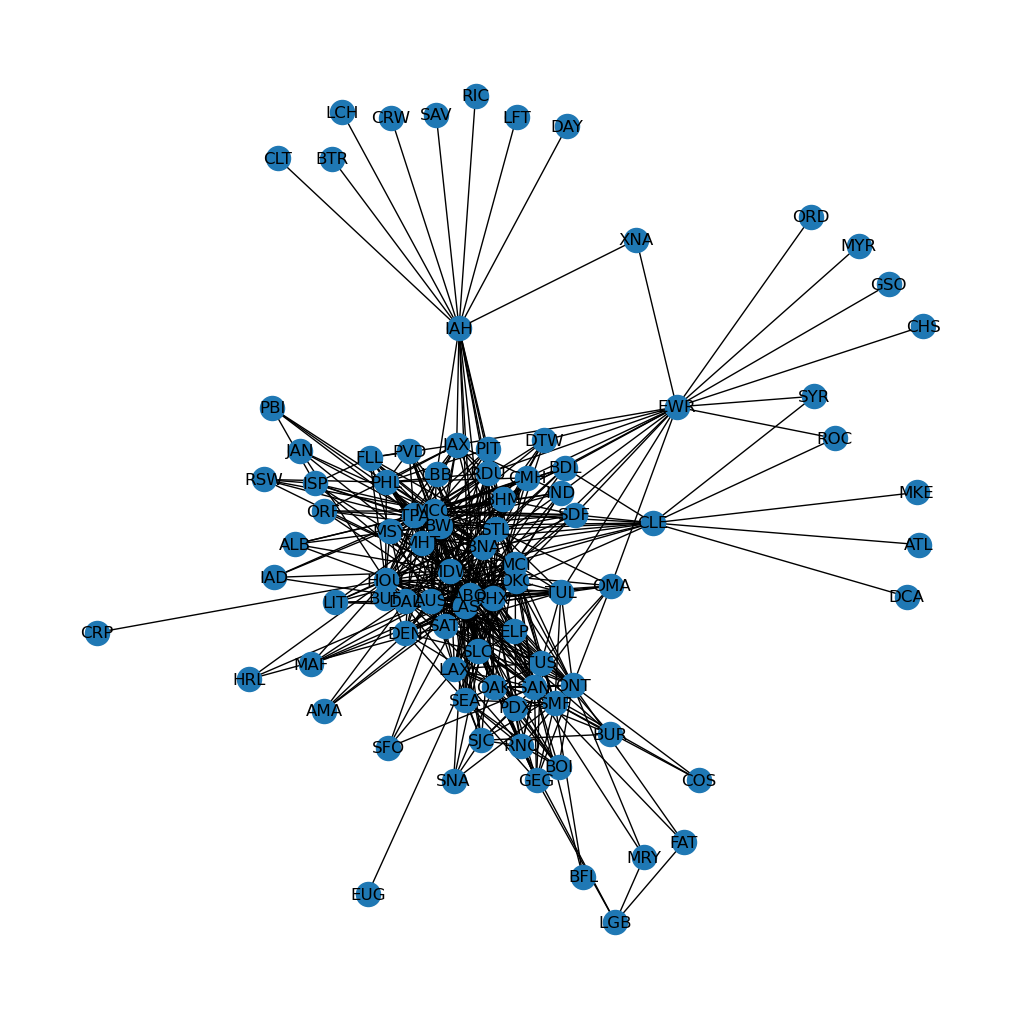

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

# Paso 1: Convertir GraphFrame a DataFrames de Spark
vertices_df = graph.vertices.toPandas()
edges_df = graph.edges.toPandas()

# Paso 2: Crear un grafo NetworkX
G = nx.Graph()

# Añadir nodos y aristas al grafo de NetworkX
for index, row in vertices_df.iterrows():
    G.add_node(row['id'])

for index, row in edges_df.iterrows():
    G.add_edge(row['src'], row['dst'])

# Paso 3: Visualizar el grafo
plt.figure(figsize=(10, 10))  # Ajusta el tamaño según necesites
nx.draw(G, with_labels=True)
plt.show()


# Persistencia del EDA

Para posteriormente probar el correcto funcionamiento del modelo, vamos a separar los datos en un 90% (para entrenar y testear el modelo) y un 10 % (para validarlo posteriormente). 

In [29]:
train_test_df, validation_df = cleanFlightsDF.randomSplit([0.9, 0.1], seed=42)

num_filas = train_test_df.count()
print("Número de filas datos train y test:", num_filas)

num_filas = validation_df.count()
print("Número de filas datos validación:", num_filas)

# Guardar los nuevos conjuntos de datos como archivos CSV
train_test_df.coalesce(1).write.mode("overwrite").option("header", "true").csv("Train_test_data", header=True)
validation_df.coalesce(1).write.mode("overwrite").option("header", "true").csv("Validation_data", header=True)

StatementMeta(upmpracticalabs, 1, 30, Finished, Available)

Número de filas datos train y test: 88834
Número de filas datos validación: 9864
